# ELBO check
> and negative beta fix

Experiment description: run victree on real dataset and assert that $\beta$ param for $q(\mu, \tau)$
wrongly gets updated to negative values. Then inspect on the reason.
Draw contributions of the total ELBO to see where partial elbos are unexpectedly large or small.

Intuitions:
- NaNs in the datasets are not correctly handled
- prior parameters are off
- bug in the code

In [1]:
# read data
from utils.data_handling import DataHandler
ov014_ds_path = "/Users/zemp/Downloads/data/signals_SPECTRUM-OV-014.h5"
dh = DataHandler(ov014_ds_path)

/Users/zemp/PycharmProjects/victree/venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/zemp/PycharmProjects/victree/venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/zemp/PycharmProjects/victree/venv/lib/python3.10/si

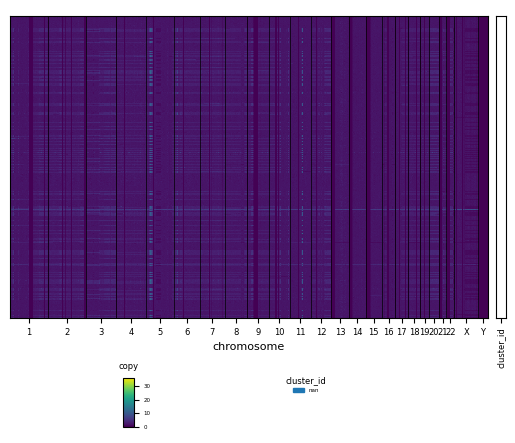

In [2]:
import scgenome.plotting as pl
%matplotlib inline

ad = dh.get_anndata()
ad.layers['copy'] = ad.X
g = pl.plot_cell_cn_matrix_fig(ad, 'copy', cell_order_fields=['cluster_id'], annotation_fields=['cluster_id'], raw=True)

In [3]:
from variational_distributions.var_dists import qCMultiChrom, qZ, qEpsilonMulti, qMuTau, qPi
# set up VI
from utils.config import Config, set_seed
from tests.utils_testing import get_tree_K_nodes_one_level
from variational_distributions.joint_dists import FixedTreeJointDist
set_seed(101)

config = Config(n_nodes=5, n_states=7, n_cells=dh.get_anndata().n_obs, chain_length=dh.get_anndata().n_vars,
                chromosome_indexes=dh.get_chr_idx(), wis_sample_size=50, step_size=0.06, debug=True)

star_tree = get_tree_K_nodes_one_level(config.n_nodes)

qc = qCMultiChrom(config).initialize(method='diploid')
qz = qZ(config).initialize(method='kmeans')
qeps = qEpsilonMulti(config, alpha_prior=1., beta_prior=5.).initialize(method='fixed-equal',
                                                                       eps_alpha=config.chain_length / 100., eps_beta=float(config.chain_length))
qmt = qMuTau(config).initialize(method='prior')
qpi = qPi(config, delta_prior=10.).initialize(method='prior')

joint_q = FixedTreeJointDist(config, qc, qz, qeps, qmt, qpi, T=star_tree, obs=dh.norm_reads)

In [4]:
import torch

for i in range(100):
    joint_q.update()
    print(f"it: {i}, elbo: {joint_q.elbo}, beta < 0: {torch.any(joint_q.mt.beta <= 0.)}")
    if i % 10 == 0:
        print(joint_q)

it: 0, elbo: -844870720.0, beta < 0: False
+++ Joint summary +++
fixed tree: (1,2,3,4)0
 ELBO: -844870720.0[qCMultiChrom summary]
-cn profile
	0:	[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
		[0.245 0.995 0.995 0.995 0.995 0.995 0.995 0.995 0.995 0.995 0.995 0.995
 0.995 0.995 0.995 0.995 0.995 0.995 0.995 0.995 0.995 0.995 0.995 0.995
 0.995 0.995 0.995 0.995 0.995 0.995]
	1:	[2 2 2 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 3 3 2 2]
		[0.247 1.    0.995 0.995 0.995 1.    0.995 1.    0.995 0.995 0.995 0.995
 0.995 0.995 0.995 0.995 0.995 0.995 0.995 0.995 0.995 0.995 0.995 0.995
 0.995 0.995 1.    1.    0.995 0.995]
	2:	[2 2 2 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 3 3 2 2]
		[0.247 1.    0.995 0.995 0.995 1.    0.995 1.    0.995 0.995 0.995 0.995
 0.995 0.995 0.995 0.995 0.995 0.995 0.995 0.995 0.995 0.995 0.995 0.995
 0.995 0.995 1.    1.    0.995 0.995]
	3:	[2 2 2 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 3 3 2 2]
		[0.247 1.    0.995 0.995 0.995 1. 

In [5]:
z = joint_q.z.pi.argmax(dim=1).numpy()
cn = joint_q.c.get_viterbi()[z].numpy()

ad.layers['victree-cn'] = cn[z]
ad.obs['victree-clone'] = z
ad.obs['victree-clone'] = ad.obs['victree-clone'].astype('category')

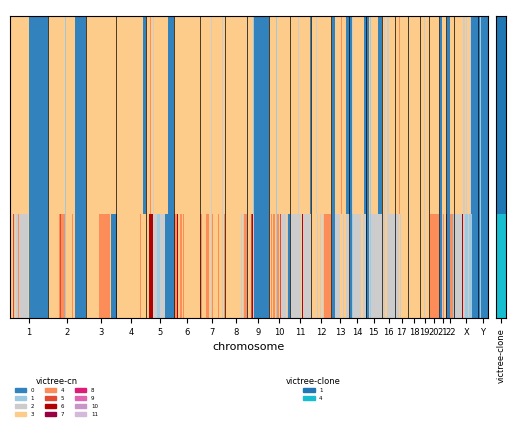

In [10]:
g = pl.plot_cell_cn_matrix_fig(ad, 'victree-cn', max_cn=6, cell_order_fields=['victree-clone'],
                               annotation_fields=['victree-clone'])